In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

In [2]:
def download_daily_data(ticker,start, end):
    data=yf.download(ticker,start,end)
    return data

In [3]:
def compute_daily_return(data):
    data['cc_return']=np.log(data['Adj Close']/data['Adj Close'].shift(1))
    return data
    

In [4]:
ticker1="MSFT"
end1 = dt.date(2020,4,30)
start1 = dt.date(2015,1,15)

In [5]:
df=download_daily_data(ticker=ticker1,start=start1,end=end1)

[*********************100%***********************]  1 of 1 completed


In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-15,46.220001,46.380001,45.410000,45.480000,39.694263,32750800
2015-01-16,45.310001,46.279999,45.169998,46.240002,40.357582,35695300
2015-01-20,46.299999,46.650002,45.570000,46.389999,40.488495,36161900
2015-01-21,45.939999,46.139999,45.480000,45.919998,40.078297,39081100
2015-01-22,46.380001,47.139999,46.080002,47.130001,41.134361,35898000


In [8]:
def compute_indicator(data):
    data['day']=data.index.day_name()
    data['prev_day']=data['day'].shift(1)
    data['four_day_after']=data['day'].shift(-4)
    
    data['relative_range'] = (data['High'] - data['Low']) / data['Adj Close']
    data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()
    
    data['ibs'] = (data['Adj Close'] - data['Low']) / (data['High'] - data['Low'])

    return data

In [17]:
def backtest_strategy(data, ibs_threshold):
    data['condition1'] = np.where((data['day'] == 'Monday') 
                            & (data['prev_day'] == 'Friday') 
                            & (data['four_day_after'] == 'Friday'), 
                            1, 0)

    data['condition2'] = np.where((1 - data['Close'] / data['Close'].shift(1))
                                  >= 0.25 * data['rel_range_ma'], 1, 0)

    data['condition3']=np.where(data['ibs']<ibs_threshold,1,0)
    data['signal'] = np.where((data['condition1']==1) 
                        & (data['condition2']==1) 
                        & (data['condition3']==1), 
                        1, 0)
    
    
    data['signal'] = data['signal'].shift(1)
    data['position'] = data['signal'].replace(to_replace=0, method='ffill', limit=3)
    

    data['strategy_returns'] = data['cc_return'] * data['position']
    return data


In [19]:
def show_backtesting_results(data):
    print('Buy and hold returns: ', np.round(data['cc_return'].cumsum()[-1], 2))
    print('Strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1], 2))
    

    data[['cc_return', 'strategy_returns',]] = data[['cc_return', 'strategy_returns']].cumsum()
    data[['cc_return', 'strategy_returns', 'position']].plot(
        secondary_y='position', grid=True, figsize=(12, 8))

Buy and hold returns:  1.36
Strategy returns:  0.65


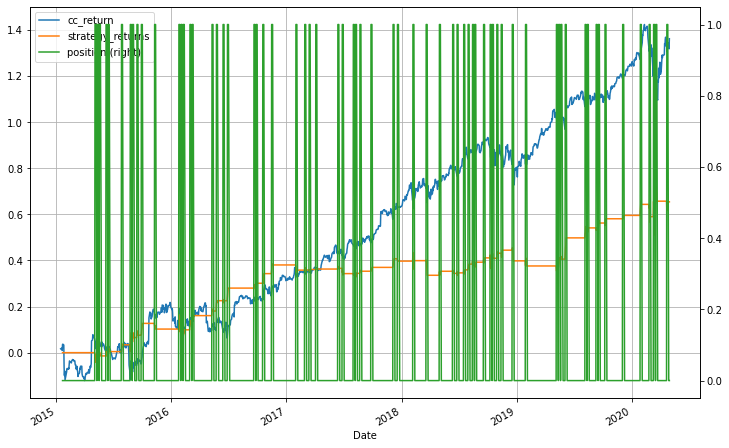

In [24]:
df = compute_daily_return(df)
df = compute_indicator(df)
data_ibs_03 = backtest_strategy(df, 0.3)
show_backtesting_results(df)


Buy and hold returns:  737.02
Strategy returns:  151.13


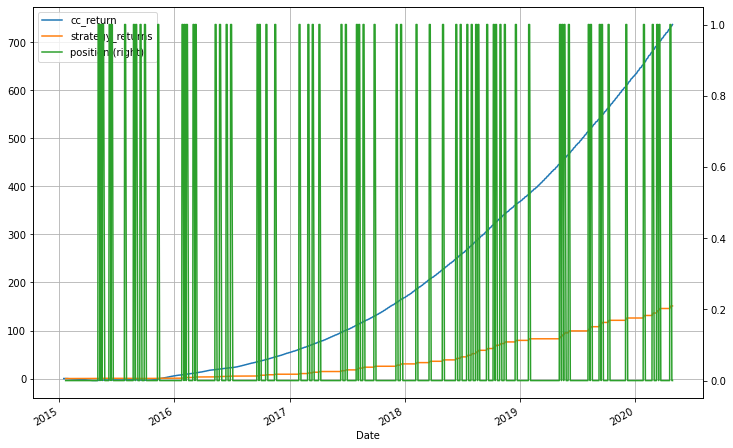

In [25]:
data_ibs_08 = backtest_strategy(df, 0.8)
show_backtesting_results(df)

#In the first scenario with an IBS threshold of 0.3, the buy-and-hold returns are 1.36 and the strategy returns are 0.65. This suggests that the strategy has underperformed compared to buy-and-hold.

#In the second scenario with an IBS threshold of 0.8, the buy-and-hold returns are 737.02 and the strategy returns are 151.13. This suggests that the strategy has outperformed buy-and-hold, but not by a large margin.

#It can be interpreted that a higher IBS threshold value might result in higher returns

#Write a customized function that computes returns for the exponential moving average (EMA) strategy (discussed in class) for different windows (spans). Find the optimal value of span between 1 and 30 which produces the best overall total return

In [45]:
df2=download_daily_data(ticker=ticker1,start=start1,end=end1)

[*********************100%***********************]  1 of 1 completed


In [46]:
# function for EMA strategy
def ema_strategy(data, span):
    data['ema'] = data['Adj Close'].ewm(span=span).mean()
    data['position'] = np.where(data['Adj Close'] > data['ema'], 1, -1)
    data['strategy_returns'] = data['cc_return'] * data['position'].shift(1)
    return data



In [47]:
# function to find the best span
def find_best_span(data):
    best_span = 0
    best_return = -np.inf
    for span in range(1, 31):
        data_span = ema_strategy(data.copy(), span)
        returns = data_span['strategy_returns'].sum()
        if returns > best_return:
            best_return = returns
            best_span = span
    return best_span, best_return

In [48]:
df2=compute_daily_return(df2)
#find the best span for EMA strategy
df2=find_best_span(df2)
print("The best span for EMA strategy is:", df2[0], "with total returns:", df2[1])

The best span for EMA strategy is: 14 with total returns: -0.6418843733002044


#best span for the EMA strategy is 14, which produced a total return of -0.6418843733002044. This means that the strategy resulted in a negative return over the specified period, but the return was the highest among all the spans tested.

Q4: The moving average crossover (MAC) code was implemented in the lecture, where we always have an open position. Try the strategy with the original conditions, tweak it and calculate returns where short selling is not allowed. Plot a graph comparing returns from buy-and-hold, no short selling, and the one we did in class. Comment on your results.

In [96]:
#function for MAC strategy
def MAC(df, short_window, long_window):
    df['SMA50'] = df['Adj Close'].rolling(window=short_window, min_periods=1).mean()
    df['SMA200'] = df['Adj Close'].rolling(window=long_window, min_periods=1).mean()
    signals = []
    for i in range(len(df)):
        if (df['SMA50'][i-1] > df['SMA200'][i-1]) & (df['SMA50'][i] < df['SMA200'][i]):
            signals.append(1)
        else:
            signals.append(0)
    df['Signal'] = signals
    df['Signal'].value_counts()
    df['Returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    df['Strategy'] = df['Signal'].shift(1) * df['Returns']
    return df

In [97]:
#fuction to backtest the mac strategy
def backtest(df):
    df['Positions'] = df['Signal'].shift(1)
    df['Returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    df['Strategy'] = df['Positions'].shift(1) * df['Returns']
    df['Buy & Hold'] = np.log(df['Adj Close']/df['Adj Close'].iloc[0])
    return df

In [128]:
df3=download_daily_data(ticker=ticker1,start=start1,end=end1)

[*********************100%***********************]  1 of 1 completed


In [116]:
df3= compute_daily_return(df3)

In [129]:
df3

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-15,46.220001,46.380001,45.410000,45.480000,39.694256,32750800
2015-01-16,45.310001,46.279999,45.169998,46.240002,40.357586,35695300
2015-01-20,46.299999,46.650002,45.570000,46.389999,40.488495,36161900
2015-01-21,45.939999,46.139999,45.480000,45.919998,40.078289,39081100
2015-01-22,46.380001,47.139999,46.080002,47.130001,41.134361,35898000
...,...,...,...,...,...,...
2020-04-23,174.110001,175.059998,170.910004,171.419998,167.106705,32790800
2020-04-24,172.059998,174.559998,170.710007,174.550003,170.157944,34277600
2020-04-27,176.589996,176.899994,173.300003,174.050003,169.670578,33194400


In [130]:
def backtest_strategy(df, m, n):
    df['sma50'] = df['Adj Close'].rolling(window=m).mean()
    df['sma200'] = df['Adj Close'].rolling(window=n).mean()
    df['sma50'] = df['sma50'].shift(1)
    df['sma200'] = df['sma200'].shift(1)
    
    df['sma50_prev_day'] = df['sma50'].shift(1)
    df['sma200_prev_day'] = df['sma200'].shift(1)
    
    df['signal'] = np.where((df['sma50'] > df['sma200']) 
                            & (df['sma50_prev_day'] < df['sma200_prev_day']), 1, 0)
    df['signal'] = np.where((df['sma50'] < df['sma200']) 
                            & (df['sma50_prev_day'] > df['sma200_prev_day']), -1, df['signal'])
    
    df['buy_price'] = df.apply(lambda x : x['Adj Close'] if x['sma50'] > x['sma200'] 
                            and x['sma50_prev_day'] < x['sma200_prev_day'] else 0, axis=1)
    df['trade_price'] = df['buy_price'] 
    df['trade_price']=df['trade_price'].replace(to_replace=0, method='ffill')
    
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')
    
    df['bnh_returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['strategy_returns'] = df['bnh_returns'] * df['position'].shift(1)
    
    bnh_return = np.round(df['bnh_returns'].cumsum()[-1], 2)
    strategy_return = np.round(df['strategy_returns'].cumsum()[-1], 2)
    
    return bnh_return, strategy_return

In [131]:
bnh_return, strategy_return = backtest_strategy(df3, m=50, n=200)
print('Buy and hold returns: ', bnh_return)
print('Strategy returns: ', strategy_return)

Buy and hold returns:  1.47
Strategy returns:  1.02


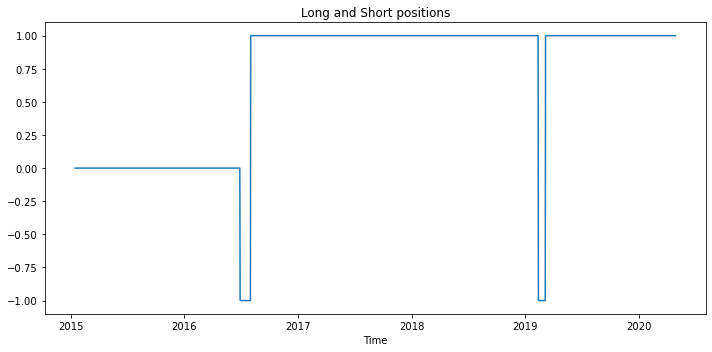

Buy and hold returns:  1.47
Strategy returns:  1.02


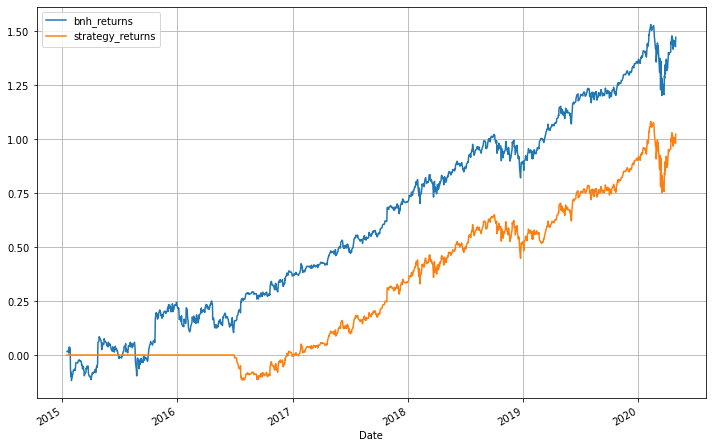

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(df3['position'])
plt.title("Long and Short positions")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

df3['bnh_returns'] = np.log(df3['Adj Close'] / df3['Adj Close'].shift(1))
df3['strategy_returns'] = df3['bnh_returns'] * df3['position'].shift(1)

df3[['bnh_returns', 'strategy_returns']].cumsum().plot(grid=True, figsize=(12, 8))

print('Buy and hold returns: ', np.round(df3['bnh_returns'].cumsum()[-1], 2))
print('Strategy returns: ', np.round(df3['strategy_returns'].cumsum()[-1], 2))

This suggests that the strategy may not be capturing as much of the upward movement in the stock as the Buy and Hold strategy, potentially due to missing out on potential profits from short selling.

Q2: You have seen a strategy based on the MACD indicator in the class. Now back-test the following strategy based on Bollinger bands:
1.	Create 20-day (+/- 2 standard deviations) Bollinger bands on the adjusted close price for the above equity.
2.	Buy when the price crosses the lower band from the top and hold until the price crosses the upper band from below the next time.
3.	Sell when the price crosses the upper band from below and hold until the price crosses the lower band from top the next time.
4.	Once we get into a trade, we always have an open position at all times.
Compare the total returns of the above strategy with a simple ‘buy & hold’ strategy. Comment on your findings. (5 Marks)


In [159]:
def bollinger_band_strategy(df):
    df["position"] = 0
    df["upper_band"] = df["Adj Close"].rolling(window=20).mean() + 2 * df["Adj Close"].rolling(window=20).std()
    df["lower_band"] = df["Adj Close"].rolling(window=20).mean() - 2 * df["Adj Close"].rolling(window=20).std()
    for i in range(0, len(df) - 1):
        if (df.iloc[i]["Adj Close"] > df.iloc[i]["upper_band"]) and (df.iloc[i + 1]["Adj Close"] < df.iloc[i + 1]["upper_band"]):
            df.at[df.index[i + 1], "position"] = -1
        elif (df.iloc[i]["Adj Close"] < df.iloc[i]["lower_band"]) and (df.iloc[i + 1]["Adj Close"] > df.iloc[i + 1]["lower_band"]):
            df.at[df.index[i + 1], "position"] = 1
    df["strategy_returns"] = df["position"] * df["cc_return"]
    df["strategy_returns"] = df["strategy_returns"].cumsum()
    return df



In [160]:

df4=download_daily_data(ticker=ticker1,start=start1,end=end1)

[*********************100%***********************]  1 of 1 completed


In [161]:
df4


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-15,46.220001,46.380001,45.410000,45.480000,39.694263,32750800
2015-01-16,45.310001,46.279999,45.169998,46.240002,40.357578,35695300
2015-01-20,46.299999,46.650002,45.570000,46.389999,40.488491,36161900
2015-01-21,45.939999,46.139999,45.480000,45.919998,40.078285,39081100
2015-01-22,46.380001,47.139999,46.080002,47.130001,41.134365,35898000
...,...,...,...,...,...,...
2020-04-23,174.110001,175.059998,170.910004,171.419998,167.106705,32790800
2020-04-24,172.059998,174.559998,170.710007,174.550003,170.157944,34277600
2020-04-27,176.589996,176.899994,173.300003,174.050003,169.670517,33194400


In [162]:
df4= compute_daily_return(df4)

In [163]:
df4=bollinger_band_strategy(df4)

In [164]:
df4

,Open,High,Low,Close,Adj Close,Volume,cc_return,position,upper_band,lower_band,strategy_returns
Date,,,,,,,,,,,
2015-01-15,46.220001,46.380001,45.410000,45.480000,39.694263,32750800,NaN,0,NaN,NaN,NaN
2015-01-16,45.310001,46.279999,45.169998,46.240002,40.357578,35695300,0.016573,0,NaN,NaN,0.000000
2015-01-20,46.299999,46.650002,45.570000,46.389999,40.488491,36161900,0.003239,0,NaN,NaN,0.000000
2015-01-21,45.939999,46.139999,45.480000,45.919998,40.078285,39081100,-0.010183,0,NaN,NaN,0.000000
2015-01-22,46.380001,47.139999,46.080002,47.130001,41.134365,35898000,0.026009,0,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,174.110001,175.059998,170.910004,171.419998,167.106705,32790800,-0.012176,0,177.827877,143.725316,1.055594
2020-04-24,172.059998,174.559998,170.710007,174.550003,170.157944,34277600,0.018095,0,178.714231,144.636563,1.055594
2020-04-27,176.589996,176.899994,173.300003,174.050003,169.670517,33194400,-0.002869,0,178.536323,147.188200,1.055594


In [167]:
print("Strategy returns:", df4["strategy_returns"].iloc[-1])


Strategy returns: 1.0555942737991706


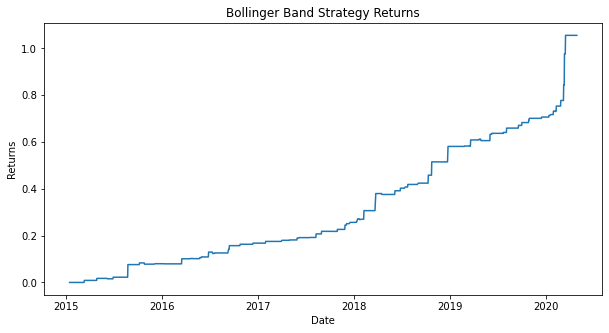

In [169]:
plt.figure(figsize=(10, 5))
plt.plot(df4.index, df4["strategy_returns"])
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Bollinger Band Strategy Returns")
plt.show()

i had the issue with BB backtesting it if u can review it and let me know it would be great